In [1]:
!python --version

Python 3.10.14


In [2]:
!python -m pip install --upgrade pip

!pip install supervision==0.3.0

!pip install transformers

!pip install pytorch-lightning

!pip install timm

!pip install cython

!pip install pycocotools

!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0


In [3]:
!pip --version

pip 24.3.1 from /opt/conda/lib/python3.10/site-packages/pip (python 3.10)


In [4]:
import torch
torch.__version__

'2.4.0'

In [5]:
import supervision
import supervision as sv
import transformers

supervision.__version__ , transformers.__version__

('0.3.0', '4.45.1')

In [6]:
import pytorch_lightning
print(pytorch_lightning.__version__)

2.4.0


In [7]:
from transformers import DetrImageProcessor
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

In [8]:
import os
import torchvision

dataset = '/kaggle/input/main-datasets/main_datasets/daytime/daytime_fold_0'

ANNOTATION_FILE_NAME = "annotations.json"
TRAIN_DIRECTORY = os.path.join(dataset, "train/image")
VAL_DIRECTORY = os.path.join(dataset, "val/image")
# TEST_DIRECTORY = os.path.join(dataset, "test")


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self, 
        image_directory_path: str, 
        image_processor, 
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)        
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(image_directory_path=TRAIN_DIRECTORY, image_processor=image_processor, train=True)
VAL_DATASET = CocoDetection(image_directory_path=VAL_DIRECTORY, image_processor=image_processor, train=False)
# TEST_DATASET = CocoDetection(image_directory_path=TEST_DIRECTORY, image_processor=image_processor, train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
# print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=1.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.83s)
creating index...
index created!
Number of training examples: 20984
Number of validation examples: 7499


Image #2393


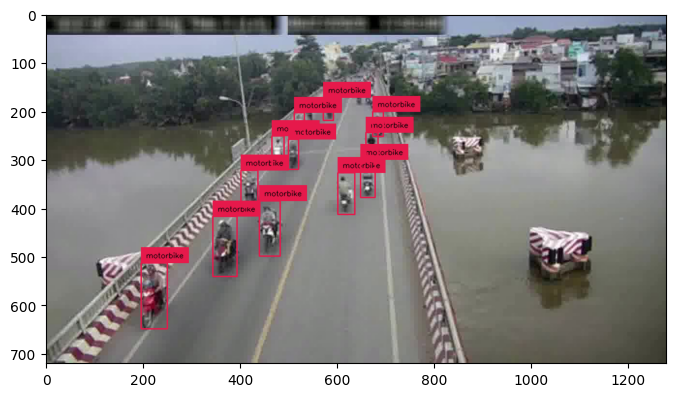

In [9]:
# Visualize if dataset is loaded properly

import random
import cv2
import numpy as np


# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons 
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

if annotations:
    # annotate
    detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

    # we will use id2label function for training
    categories = TRAIN_DATASET.coco.cats
    id2label = {k: v['name'] for k,v in categories.items()}

    labels = [
        f"{id2label[class_id]}" 
        for _, _, class_id, _ 
        in detections
    ]

    box_annotator = sv.BoxAnnotator()
    frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

    %matplotlib inline  
    sv.show_frame_in_notebook(image, (8, 8))

In [10]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)

In [11]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch

CHECKPOINT = "facebook/detr-resnet-50"

class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path=CHECKPOINT, 
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )
        
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())
            
        return loss

    def configure_optimizers(self):
        # DETR authors decided to use different learning rate for backbone
        # you can learn more about it here: 
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

In [12]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

batch = next(iter(TRAIN_DATALOADER))
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [13]:
from pytorch_lightning import Trainer

# settings
MAX_EPOCHS = 2

trainer = Trainer(devices=2, accelerator="gpu", max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5)

trainer.fit(model)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('validation/loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('validation_loss_ce', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('validation_loss_bbox', ..., sync_dist=True)` when l

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
!python -c "from huggingface_hub.hf_api import HfFolder; HfFolder.save_token('YOUR_TOKEN')"

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [15]:
model.model.push_to_hub("BjngChjjljng/detr-daytime-fold-0")
image_processor.push_to_hub("BjngChjjljng/detr-daytime-fold-0")

model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/BjngChjjljng/detr-daytime-fold-0/commit/3a96fd57caf864de474469d1c7eed15574124ca1', commit_message='Upload processor', commit_description='', oid='3a96fd57caf864de474469d1c7eed15574124ca1', pr_url=None, repo_url=RepoUrl('https://huggingface.co/BjngChjjljng/detr-daytime-fold-0', endpoint='https://huggingface.co', repo_type='model', repo_id='BjngChjjljng/detr-daytime-fold-0'), pr_revision=None, pr_num=None)

In [16]:
# from transformers import DetrImageProcessor, DetrForObjectDetection
# import torch

# model = DetrForObjectDetection.from_pretrained("/kaggle/input/detr-outputs-v3/detr_outputs_v3", id2label={0:"motorbike", 1: "car", 2: "coach", 3: "truck"})
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# image_processor = DetrImageProcessor.from_pretrained("/kaggle/input/detr-outputs-v3/detr_outputs_v3")

In [17]:
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection
import cv2
import matplotlib.pyplot as plt

# Định nghĩa hàm dự đoán
def predict_on_image(image_path):
    # Đọc ảnh
    image = cv2.imread(image_path)
    inputs = image_processor(images=image, return_tensors='pt').to("cuda" if torch.cuda.is_available() else "cpu")
    
    # Thực hiện dự đoán
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Kích thước ảnh đầu ra
    target_sizes = torch.tensor([image.shape[:2]]).to("cuda" if torch.cuda.is_available() else "cpu")
    results = image_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.3)[0]
    
    # Vẽ bounding box lên ảnh
    for box, score, label_id in zip(results['boxes'], results['scores'], results['labels']):
        if score > 0.6:  # Sử dụng ngưỡng mà bạn đã quyết định
            label = f"{model.config.id2label[label_id.item()]}: {score:.2f}"
            box = [int(coord.item()) for coord in box]  # Chuyển đổi tọa độ box thành số nguyên
            
            # Vẽ bounding box
            cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), color=(255, 0, 0), thickness=2)  # Màu đỏ
            
            # Thêm nền cho text
            text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 1)[0]
            text_bg = (box[0], box[1] - text_size[1] - 10, box[0] + text_size[0], box[1])
            cv2.rectangle(image, (text_bg[0], text_bg[1]), (text_bg[2], text_bg[3]), (255, 255, 255), thickness=cv2.FILLED)
            
            # Vẽ văn bản
            cv2.putText(image, label, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2, cv2.LINE_AA)
    
    # Hiển thị ảnh
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Thử nghiệm với một hình ảnh
image_path = '/kaggle/input/test-dataset/public test/src_1_frame_199_jpg.rf.7992e359696bc914bf0d244d0b6c0b63.jpg'
predict_on_image(image_path)


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
!pip install -q coco-eval

In [ ]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [ ]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

import numpy as np

# initialize evaluator with ground truth (gt)
evaluator = CocoEvaluator(coco_gt=VAL_DATASET.coco, iou_types=["bbox"])

print("Running evaluation...")
for idx, batch in enumerate(tqdm(VAL_DATALOADER)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = image_processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)

    # provide to metric
    # metric expects a list of dictionaries, each item
    # containing image_id, category_id, bbox and score keys
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

In [ ]:
import os
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection
import cv2

# Đường dẫn đến thư mục chứa ảnh và file kết quả
image_folder = r'/kaggle/input/test-dataset/public test'
output_file = r'/kaggle/working/predict.txt'


# Hàm chuyển đổi bounding box sang định dạng YOLO
def convert_bbox_to_yolo(box, image_width, image_height):
    x_min, y_min, x_max, y_max = box
    bbox_width = x_max - x_min
    bbox_height = y_max - y_min
    x_center = x_min + bbox_width / 2
    y_center = y_min + bbox_height / 2
    
    # Chuyển đổi tọa độ sang tỷ lệ (0-1)
    return [
        x_center / image_width,
        y_center / image_height,
        bbox_width / image_width,
        bbox_height / image_height
    ]

# Tạo hoặc mở file để ghi kết quả
with open(output_file, 'w') as f:
    
    index = 0
    
    # Duyệt qua tất cả các ảnh trong thư mục
    for image_name in os.listdir(image_folder):
        
        print(index)
        index += 1
        
        
        if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(image_folder, image_name)
            image = cv2.imread(image_path)
            img_height, img_width = image.shape[:2]

            # Chuẩn bị đầu vào
            inputs = image_processor(images=image, return_tensors='pt').to(device)
            
            # Dự đoán
            with torch.no_grad():
                outputs = model(**inputs)

            # Xử lý kết quả
            target_sizes = torch.tensor([image.shape[:2]]).to("cuda" if torch.cuda.is_available() else "cpu")
            results = image_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.3)[0]

            # Lặp qua các kết quả và ghi vào file
            for box, score, label_id in zip(results['boxes'], results['scores'], results['labels']):
                if score > 0.7:
                    yolo_bbox = convert_bbox_to_yolo([coord.item() for coord in box], img_width, img_height)
                    yolo_bbox_str = ' '.join([f"{coord:.8f}" for coord in yolo_bbox])
                    class_id = label_id.item()
                    f.write(f"{image_name} {class_id} {yolo_bbox_str} {score:.8f}\n")

print("Hoàn thành dự đoán và ghi kết quả vào file predict.txt.")